<a href="https://colab.research.google.com/github/VridhiGandhi/Music-Recommendation-System/blob/main/Music_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Install the 'implicit' library
# This library is used for implicit feedback collaborative filtering models
# The recommender in this project uses ALS (Alternating Least Squares) from 'implicit'
!pip install implicit


In [7]:
# We’re calling in some helpers first:
from pathlib import Path # This helps us work with file paths in a clean way
import scipy # This library has math & data tools, especially for large, sparse data
import pandas as pd # This is our table/matrix-handling superstar

# Imagine we’ve got a huge concert attendance sheet:
#   - Rows: Users
#   - Columns: Artists
#   - Cell value: How many times a user listened to an artist (or some "weight")
# Most of it is empty (users haven’t listened to most artists) → that’s called "sparse data".


# This function is our “data loader” that reads that sheet
def load_user_artists(user_artists_file: Path) -> scipy.sparse.csr_matrix:
    # Step 1: Read the file into a pandas DataFrame
    #   The file has columns: userID, artistID, weight
    #   sep="\t" means it’s tab-separated
    user_artists = pd.read_csv(user_artists_file, sep="\t")

    # Step 2: Tell pandas that the (userID, artistID) pair is the unique key/index
    user_artists.set_index(["userID", "artistID"], inplace=True)

    # Step 3: Create a COO (Coordinate) sparse matrix from the data
    #   - Data values: user_artists.weight.astype(float)
    #   - Row positions: userID
    #   - Column positions: artistID
    coo = scipy.sparse.coo_matrix(
        (
            user_artists.weight.astype(float),
            (
                user_artists.index.get_level_values(0),
                user_artists.index.get_level_values(1),
            ),
        )
    )
    # Step 4: Convert COO to CSR (Compressed Sparse Row) format for fast math operations
    return coo.tocsr()


# Now, let’s make a helper that can turn artist IDs into human-readable names
class ArtistRetriever:
    def __init__(self):
        self._artists_df = None  # Placeholder for the artist info table

    def get_artist_name_from_id(self, artist_id: int) -> str:
        # Look up the artist's name using the ID
        return self._artists_df.loc[artist_id, "name"]

    def load_artists(self, artists_file: Path) -> None:
        # Step 1: Read the artists file into a DataFrame
        #   This file probably has: id, name, other info
        artists_df = pd.read_csv(artists_file, sep="\t")

        # Step 2: Make the 'id' column the index for quick lookup
        artists_df = artists_df.set_index("id")

        # Step 3: Store it so we can use it later
        self._artists_df = artists_df


In [8]:
# Import the implicit library (for collaborative filtering) and scipy (for sparse matrices)
import implicit
import scipy

# Define a recommender class that uses the implicit library
class ImplicitRecommender:
    def __init__(self, artist_retriever: ArtistRetriever,
                 implicit_model: implicit.recommender_base.RecommenderBase):
        # Store the artist retriever (to get artist names) and the recommendation model
        self.artist_retriever = artist_retriever
        self.implicit_model = implicit_model

    def fit(self, user_artists_matrix: scipy.sparse.csr_matrix) -> None:
        """
        Train the implicit model on the user-artists sparse matrix.
        """
        self.implicit_model.fit(user_artists_matrix)

    def recommend(self, user_id: int, user_artists_matrix: scipy.sparse.csr_matrix,
                  n: int = 10):
        """
        Recommend 'n' artists for a given user ID.
        """
        # Get top 'n' recommended artist IDs and their scores for the given user
        artist_ids, scores = self.implicit_model.recommend(user_id, user_artists_matrix[n], N=n)

        # Convert artist IDs to artist names
        artists = [self.artist_retriever.get_artist_name_from_id(artist_id) for artist_id in artist_ids]

        return artists, scores


# --- Running the recommender system ---

# Load the user-artist interaction matrix from file
user_artists = load_user_artists("/content/user_artists.dat")

# Create an ArtistRetriever object and load artist details
artist_retriever = ArtistRetriever()
artist_retriever.load_artists("/content/artists.dat")

# Initialize the ALS (Alternating Least Squares) model from implicit
implicit_model = implicit.als.AlternatingLeastSquares(
    factors=50,        # Number of latent factors
    iterations=10,     # Number of iterations for training
    regularization=0.01 # Regularization parameter
)

# Create our custom recommender instance with the artist retriever and ALS model
recommender = ImplicitRecommender(artist_retriever, implicit_model)

# Train the model with the user-artist data
recommender.fit(user_artists)

# Get top 5 recommendations for user with ID 2
artists, scores = recommender.recommend(2, user_artists, n=5)

# Print each recommended artist with its score
for artist, score in zip(artists, scores):
    print(f"{artist}: {score}")


/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

Norah Jones: 1.5384564399719238
The Cardigans: 1.51261568069458
Jack Johnson: 1.434660792350769
Darren Hayes: 1.2349650859832764
Pet Shop Boys: 1.2018167972564697




# Music Recommendation System — Step-by-Step Processing Guide

This document explains how the music recommendation system processes data from raw files to generating personalized artist recommendations, broken down step-by-step with examples.

---

## Step 1: Load User-Artist Interaction Data

**Goal:** Read the listening data showing which user listened to which artist and how many times (or how much weight).

* Input file: `user_artists.dat` (tab-separated file with columns `userID`, `artistID`, `weight`).

**What happens:**

* The file is loaded into a pandas DataFrame.
* The `(userID, artistID)` pair is set as the index.
* This indexed data is converted into a sparse matrix format to efficiently store the mostly empty interactions.

**Example data snippet:**

| userID | artistID | weight |
| ------ | -------- | ------ |
| 1      | 101      | 15     |
| 1      | 102      | 5      |
| 2      | 101      | 7      |
| 3      | 103      | 10     |

**Code snippet:**

```python
user_artists = pd.read_csv(user_artists_file, sep="\t")
user_artists.set_index(["userID", "artistID"], inplace=True)
coo = scipy.sparse.coo_matrix(
    (
        user_artists.weight.astype(float),
        (
            user_artists.index.get_level_values(0),
            user_artists.index.get_level_values(1),
        ),
    )
)
user_artists_matrix = coo.tocsr()
```

**Result:**
A sparse matrix `user_artists_matrix` where rows = user IDs, columns = artist IDs, and values = weights (play counts).

---

## Step 2: Load Artist Metadata

**Goal:** Map artist IDs to readable artist names for output.

* Input file: `artists.dat` (tab-separated file with columns `id`, `name`, etc.)

**What happens:**

* The file is loaded into a pandas DataFrame.
* The `id` column is set as the index for fast lookup.

**Example data snippet:**

| id  | name            |
| --- | --------------- |
| 101 | Coldplay        |
| 102 | Oasis           |
| 103 | Robbie Williams |

**Code snippet:**

```python
artists_df = pd.read_csv(artists_file, sep="\t")
artists_df = artists_df.set_index("id")
```

**Result:**
A DataFrame stored inside the `ArtistRetriever` object to translate artist IDs to names.

---

## Step 3: Train the Implicit ALS Model

**Goal:** Learn latent factors representing users’ music tastes and artists' characteristics using ALS.

* Input: Sparse user-artist interaction matrix from Step 1.

**What happens:**

* Initialize the ALS model with parameters like number of factors, iterations, and regularization.
* Fit the model on the sparse matrix to learn latent factors.

**Code snippet:**

```python
implicit_model = implicit.als.AlternatingLeastSquares(
    factors=50,
    iterations=10,
    regularization=0.01
)
implicit_model.fit(user_artists_matrix)
```

**Result:**
Model trained to understand patterns in the user listening data.

---

## Step 4: Generate Recommendations for a User

**Goal:** For a specific user, find artists they haven’t listened to but are likely to enjoy.

* Input: User ID (e.g., `2`), trained model, and user-artist matrix.

**What happens:**

* The model recommends the top N artist IDs based on similarity in latent space.
* Artist IDs are translated to artist names using the `ArtistRetriever`.

**Code snippet:**

```python
artist_ids, scores = implicit_model.recommend(user_id, user_artists_matrix[user_id], N=5)
artists = [artist_retriever.get_artist_name_from_id(artist_id) for artist_id in artist_ids]
```

**Example output:**

| Artist Name     | Score |
| --------------- | ----- |
| Coldplay        | 1.23  |
| Oasis           | 1.21  |
| Robbie Williams | 1.18  |

---

## Step 5: Display Recommendations

**Goal:** Present the top recommended artists with confidence scores to the user.

**Code snippet:**

```python
for artist, score in zip(artists, scores):
    print(f"{artist}: {score}")
```

**Result:**
A readable list of recommended artists printed out, helping the user discover new music based on their listening habits.

---


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


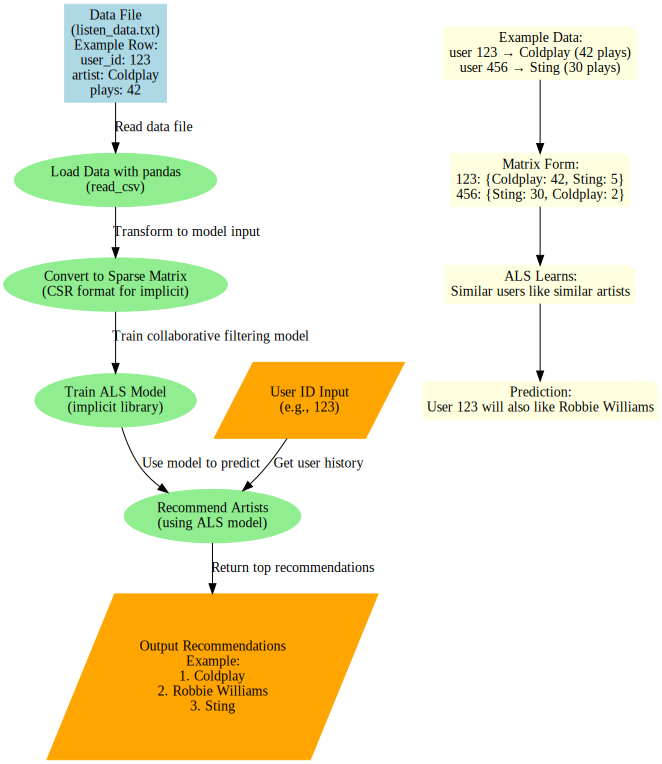

In [ ]:
# Install required libraries
!apt-get install -y graphviz
!pip install graphviz

from graphviz import Digraph

# Create the graph
dot = Digraph(comment='Implicit ALS Recommendation Flow', format='png')

# ========================
# NODE STYLES:
# Rectangle = file/data
# Ellipse = process
# Parallelogram = input/output
# Colors: lightblue=data, lightgreen=processing, orange=input/output
# ========================

# Data File
dot.node('A', 'Data File\n(listen_data.txt)\nExample Row:\nuser_id: 123\nartist: Coldplay\nplays: 42',
         shape='rectangle', style='filled', color='lightblue')

# Load Data
dot.node('B', 'Load Data with pandas\n(read_csv)',
         shape='ellipse', style='filled', color='lightgreen')

# Convert to Sparse Matrix
dot.node('C', 'Convert to Sparse Matrix\n(CSR format for implicit)',
         shape='ellipse', style='filled', color='lightgreen')

# Train ALS Model
dot.node('D', 'Train ALS Model\n(implicit library)',
         shape='ellipse', style='filled', color='lightgreen')

# User ID Input
dot.node('E', 'User ID Input\n(e.g., 123)',
         shape='parallelogram', style='filled', color='orange')

# Recommend Artists
dot.node('F', 'Recommend Artists\n(using ALS model)',
         shape='ellipse', style='filled', color='lightgreen')

# Output Recommendations
dot.node('G', 'Output Recommendations\nExample:\n1. Coldplay\n2. Robbie Williams\n3. Sting',
         shape='parallelogram', style='filled', color='orange')

# ========================
# EDGES (FLOW)
# ========================
dot.edge('A', 'B', label='Read data file')
dot.edge('B', 'C', label='Transform to model input')
dot.edge('C', 'D', label='Train collaborative filtering model')
dot.edge('E', 'F', label='Get user history')
dot.edge('D', 'F', label='Use model to predict')
dot.edge('F', 'G', label='Return top recommendations')

# ========================
# SIDE EXAMPLE FLOW
# ========================

# Example user data steps
dot.node('X1', 'Example Data:\nuser 123 → Coldplay (42 plays)\nuser 456 → Sting (30 plays)',
         shape='note', style='filled', color='lightyellow')

dot.node('X2', 'Matrix Form:\n123: {Coldplay: 42, Sting: 5}\n456: {Sting: 30, Coldplay: 2}',
         shape='note', style='filled', color='lightyellow')

dot.node('X3', 'ALS Learns:\nSimilar users like similar artists',
         shape='note', style='filled', color='lightyellow')

dot.node('X4', 'Prediction:\nUser 123 will also like Robbie Williams',
         shape='note', style='filled', color='lightyellow')

# Connect side example
dot.edge('X1', 'X2')
dot.edge('X2', 'X3')
dot.edge('X3', 'X4')

# Render and show
dot.render('als_detailed_flow', cleanup=True)
dot
